# Ajinomoto Data Analysis Notebook

In this notebook we compile all assays performed for the Ajinomoto Project on *E. coli* strains that were designed to produce the C12 Fatty alcohol dodecanol. Two complete cycles of design build test learn [DBTL] were performed. This document is a reproducable record of all analyses that were performed on the data and the resulting conclusions.

**Analysis TODOs:**

1. [ ] Cycle 1 OD Data
1. [ ] Control for Origin of Replication Copy Number for All Strains (Add Copy Number to Data)
5. [?] Normalize Heatmap TIRs on a per RBS basis... This might be done already... IT will just be less obvious with cycle 2 strains...
2. [X] Test Creation of models using averaged replicates
3. [X] Incorporate Toxicity (OD) data 
4. [X] Remove Invalid HPLC Measurements!
1. [X] Plot Interesting Correlations
10. [X] Perform Basic Correlations with Adjustment at 95% Confidence
4. [X] Add white blocks where there is no information on the heatmap!
8. [X] Engineering Analysis: Does Upstream protein expression effect 
3. [X] Doublecheck RBS Values with strains (as per harrys request)
2. [X] Add Error Bars to Predicted vs. Actual Plots.
6. [X] Build Batch to Batch Variation Plots
7. [X] Build Engineering Accuracy Analaysis

**ART Todos:**
1. [X] Modify Art so It can Generate a MSE Score Regardless of input sample size (samples must be greater than 2)
2. [X] Convert Model Evaluation to Use MSE instead of average error mean and standard deviation
3. [X] Make Art Correctly Evaluate Weights by using -1* the input for the softmax function (also normalize based on max value minus outliars)
5. [X] Fix ART Generate Report 


**TODO (Optional):**
3. [ ] Build Toxicity Model using OD data
4. [ ] Fix Art Bounds to be specific to variance along each direction.
2. [ ] Check Art Branches & See if I need to Merge?


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

#Import data into pandas dataframe
df = pd.read_csv('data/EDD_Ajinomoto_Data.csv',header=[0, 1], index_col=0, skipinitialspace=False)

### 1. Quality Checking and Data Cleaning

The data is cleaned and then measured for quality.

In [2]:
#Before Cleanup add some important columns for the analysis

#Add a Total Fatty Alcohols Column
df[('GC-MS','Total Fatty Alcohols')] = df['GC-MS'].sum(axis=1)

#### Proteomics Cleanup
We check to make sure protein is produced if and only if the associated gene is expressed. Some Protomics data suggests the presence of proteins in strains which were not present in the vectors. These protein counts are zeroed out to remove the spurious measurements if they are close to zero.

In [3]:
#Proteomics Clean-Up
from utility import clean_proteomics
df.loc[df[('Metadata','Cycle')]>0,df.columns.get_level_values(0)=='Targeted Proteomics'] = df.loc[df[('Metadata','Cycle')]>0].apply(clean_proteomics,axis=1).values

#### General Cleanup
Data points with a coefficient of variation over the threshold are removed. Optionally, everything below the given detection threshold is zeroed out for an assay.

In [4]:
#Clean Data 
from utility import clean_data
assay_types = ['GC-MS','LC-MS','HPLC','NIMS','Targeted Proteomics']
assay_df_slice = df.loc[:,df.columns.get_level_values(0).isin(assay_types+['Metadata'])]
df.loc[:,df.columns.get_level_values(0).isin(assay_types)] = clean_data(assay_df_slice,CoV_threshold=0.5)

Now that the data is cleaned we can visualize the Coefficient of Variation of The measurements for each assay type.

In [5]:
from plot import quality_plot, strain_heatmap,strain_plot3d
#strain_heatmap(df.loc[df[('Metadata','Pathway')].isin([1,2,3])])
#quality_plot(df,assay_types)

group_columns = [('Metadata',col) for col in ['Cycle','Strain','IPTG']]
strain_plot3d(df.groupby(group_columns).mean().reset_index(),pathway=1)

#### Comprehensive Batch Effect Analysis

In order to ensure that experimental measurement variations accurately represent the biology instead of the assay technique we conduct a series of batch to batch constistency checks. To do this we look for strains that had the same genotype and experimental conditions and were used in multiple batches. The Assays are plotted for that strain across the batches.

/Users/zakcostello/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/zakcostello/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning:

remove_na is deprecated and is a private function. Do not use.



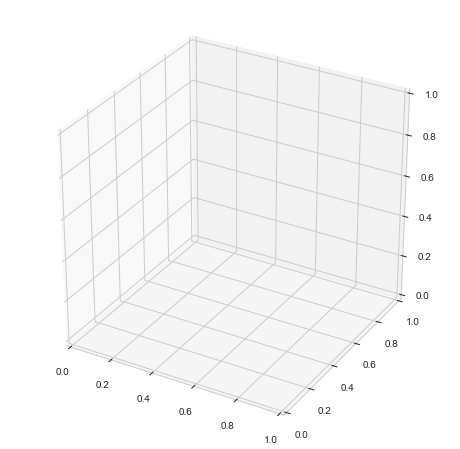

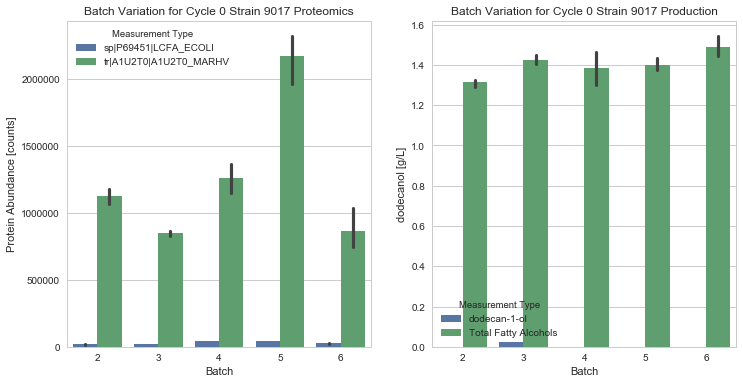

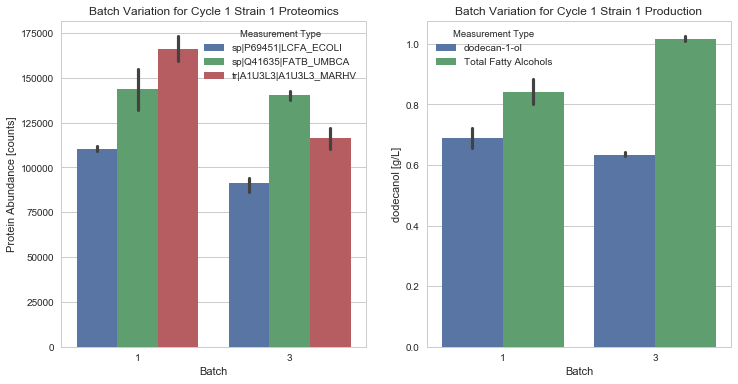

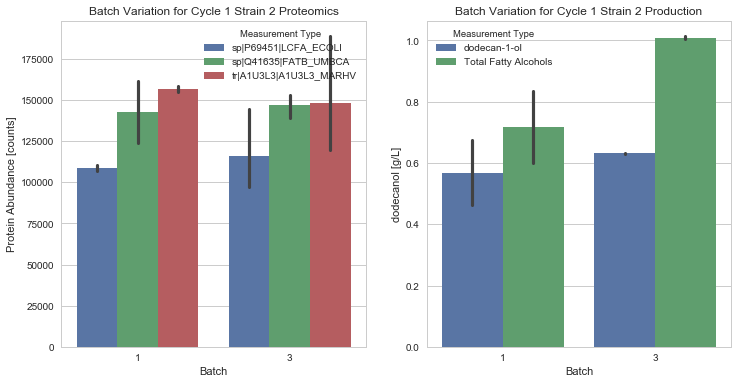

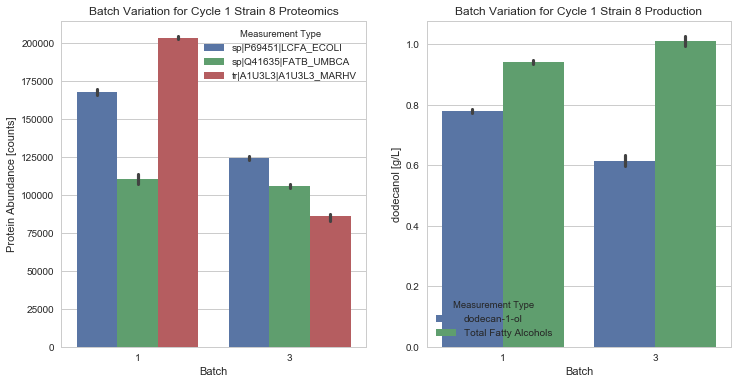

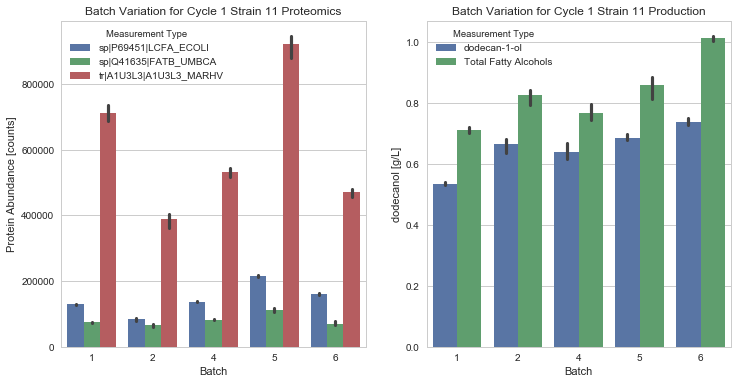

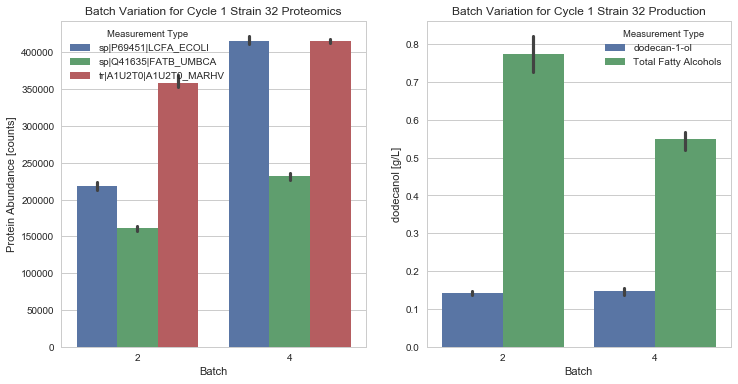

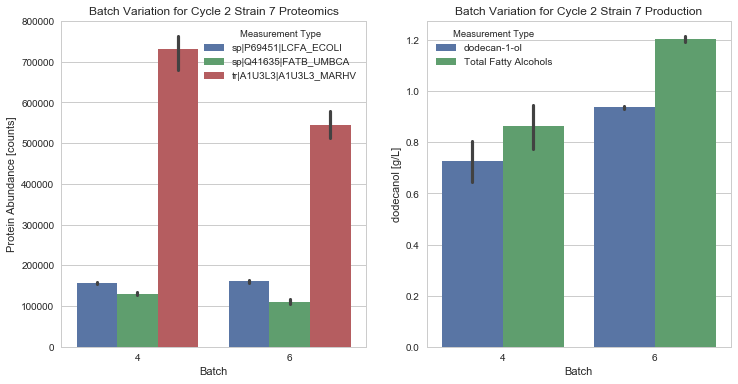

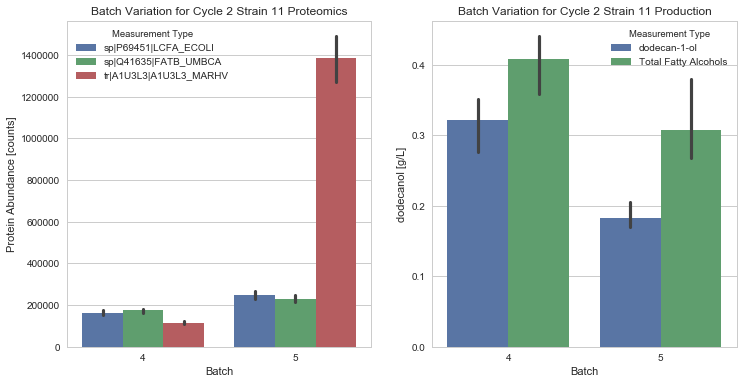

In [6]:
#Group Strains that are in multiple batches (Conditions Must be held constant)
conditions = [('Metadata','Cycle'),('Metadata','Strain'),('Metadata','IPTG')]
strain_groups = df.groupby(conditions)
for group in strain_groups:
    cycle,strain,iptg = group[0]
    strain_df = group[1]
    
    
    #Check to see if there are multiple batches in the strain
    if len(strain_df[('Metadata','Batch')].unique()) > 1:
        
        protein_columns = strain_df.columns[((strain_df>1e4)|strain_df.isnull()).all(axis=0) & (strain_df.columns.get_level_values(0)=='Targeted Proteomics')]
        strain_df = strain_df.dropna(subset=protein_columns)
        strain_df.loc[:,('Metadata','Batch')] = strain_df[('Metadata','Batch')].apply(lambda x: int(x))
        
        protein_df = strain_df[list(protein_columns)+[('Metadata','Batch')]].melt(id_vars=[('Metadata','Batch')],value_vars=list(protein_columns))
        production_df = strain_df[[('GC-MS','Total Fatty Alcohols'),('GC-MS','dodecan-1-ol'),('Metadata','Batch')]].melt(id_vars=[('Metadata','Batch')],value_vars=[('GC-MS','dodecan-1-ol'),('GC-MS','Total Fatty Alcohols')])
        
        if len(protein_df) > 0:
            plt.figure(figsize=(12,6))
            
            #Protein Plot
            plt.subplot(1,2,1)
            sns.barplot(x=('Metadata','Batch'),y='value',hue='Measurement Type',data=protein_df)
            plt.title('Batch Variation for Cycle {} Strain {} Proteomics'.format(int(cycle),strain))
            plt.ylabel('Protein Abundance [counts]')
            plt.xlabel('Batch')

            #Production Plot
            plt.subplot(1,2,2)
            sns.barplot(x=('Metadata','Batch'),y='value',hue='Measurement Type',data=production_df)
            plt.title('Batch Variation for Cycle {} Strain {} Production'.format(int(cycle),strain))
            plt.ylabel('dodecanol [g/L]')
            plt.xlabel('Batch')
            
            plt.savefig('figures/BatchEffects_Cycle{}Strain{}'.format(int(cycle),strain),dpi=600)
            plt.show()
        

### 2. Engineering Accuracy
We analyze the success of the predictive tools in hitting target protein levels in different constructs.

Pathway 1, RBS Calculator: EMOPEC


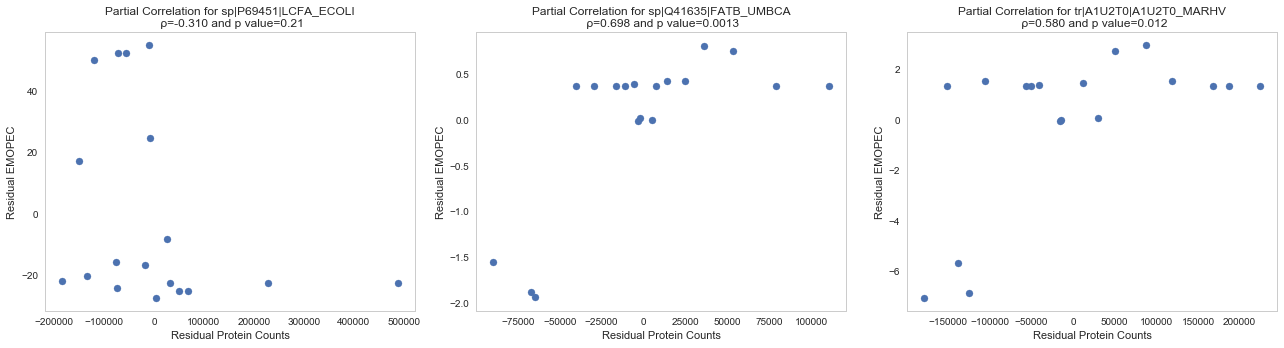

Pathway 1, RBS Calculator: TIR


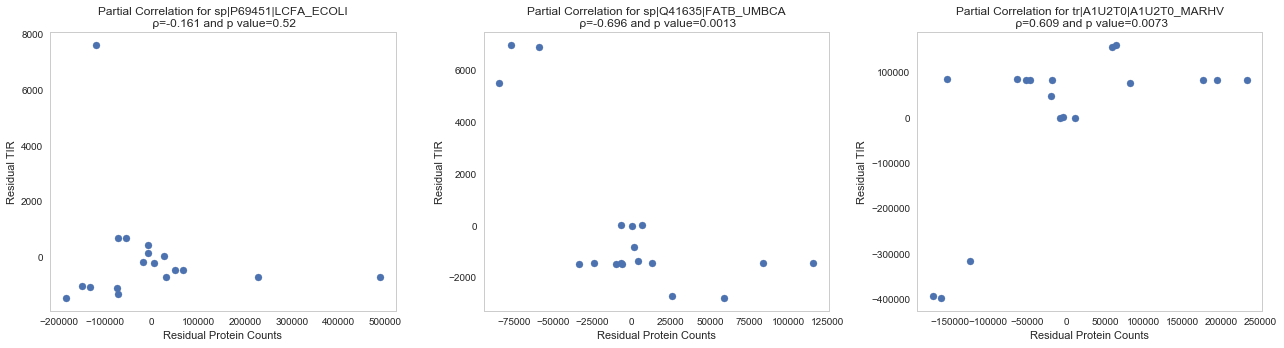

Pathway 2, RBS Calculator: EMOPEC


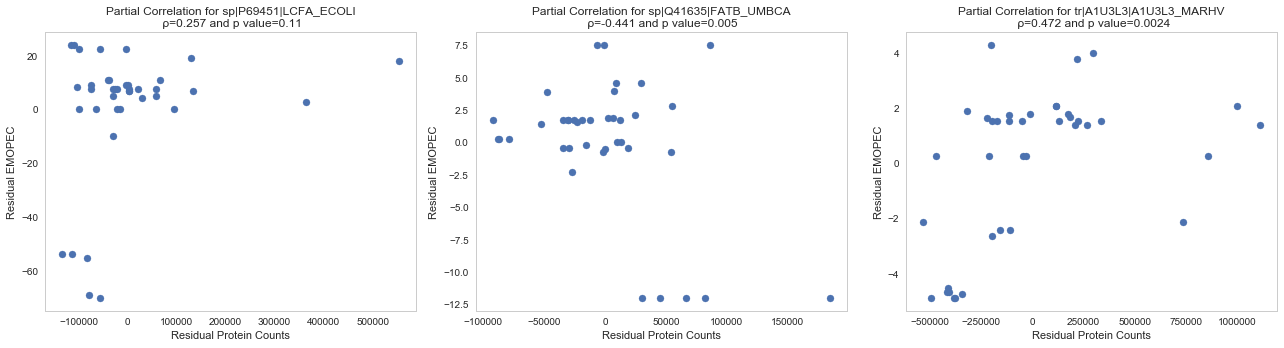

Pathway 2, RBS Calculator: TIR


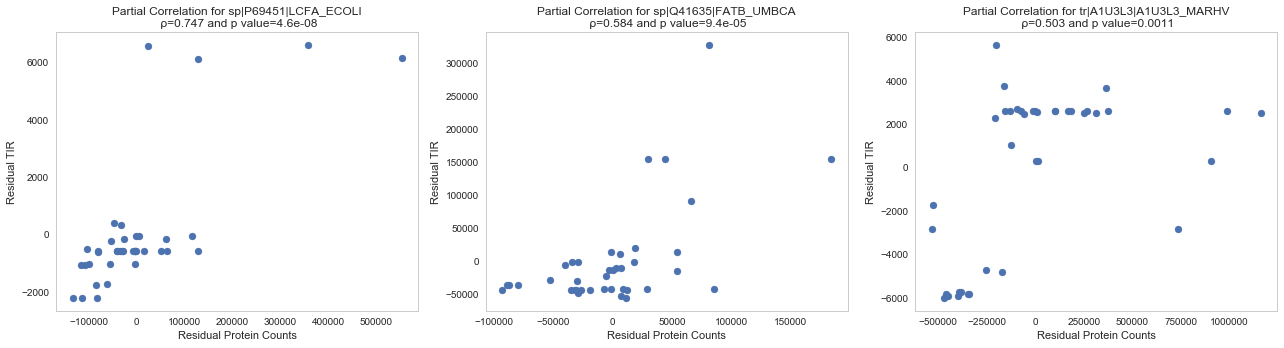

In [12]:
#Check to see if there are correlations between rbs and production after controlling for context (partial correlation)
from utility import partial_correlation

#First Check for Maqu2507 Strains look at each one controling for other TIRs/EMOPECs
for pathway in [1,2]:
    pathway_df = df.loc[df[('Metadata','Pathway')]==pathway]
    compare_columns = pathway_df.columns[pathway_df.columns.get_level_values(0).isin(['Targeted Proteomics','TIR','EMOPEC'])]
    grouping = [('Metadata','Cycle'),('Metadata','Strain'),('Metadata','IPTG'),('Metadata','Batch')]
    pathway_df = pathway_df.dropna(subset=compare_columns).groupby(grouping).mean()

    proteins = pathway_df.columns[((pathway_df>1e3)|pathway_df.isnull()).all(axis=0) & (pathway_df.columns.get_level_values(0)=='Targeted Proteomics')]

    #print(list(proteins))
    for rbs_calculator in ['EMOPEC','TIR']:
        print('Pathway {}, RBS Calculator: {}'.format(pathway,rbs_calculator))

        plt.figure(figsize=(18,5))
        for i,(data_type,protein) in enumerate(proteins):

            #Independent Variable
            X = pathway_df[data_type].loc[:,protein]
            
            #Dependent Variable
            Y = pathway_df[rbs_calculator].loc[:,protein]

            #Controlling Variables
            control_vars = [(rbs_calculator,p) for _,p in proteins if p != protein]
            control_vars.append(('Metadata','Copy Number'))
            Z = pathway_df.loc[:,control_vars]
            Z['Ones'] =  np.ones(len(X))

            #Perform partial_correlation
            corr,p_val,e_x,e_y = partial_correlation(X,Y,Z)

            #Plot Error residuals that form the correlation
            plt.subplot(1,3,i+1)
            plt.scatter(e_x,e_y)
            
            plt.gca().set_axisbelow(True)
            plt.grid()
            plt.ylabel('Residual {}'.format(rbs_calculator))
            plt.xlabel('Residual Protein Counts')
            plt.title('Partial Correlation for {}\n ρ={:0.3f} and p value={:0.2g}'.format(protein,corr,p_val))

        plt.tight_layout()
        plt.savefig('figures/engineering_pathway{}_{}.png'.format(pathway,rbs_calculator),dpi=600)
        plt.show()


In [ ]:
#Check the relationship between proteins modulated by strains and 
from scipy import stats
import matplotlib.ticker as ticker

#Strain Comparison
strain_groups = ([5,6,7,8,9],[1,2,3,4],[15,16,17,18,19,20])
reductases = ['tr|A1U3L3|A1U3L3_MARHV','tr|A1U3L3|A1U3L3_MARHV','tr|A1U2T0|A1U2T0_MARHV']
group_criteria = [('Metadata','Strain'),('Metadata','Cycle'),('Metadata','Batch'),('Metadata','IPTG')]
for strains,reductase in zip(strain_groups,reductases):
    plot_df = df.loc[(df[('Metadata','Strain')].isin(strains))&(df[('Metadata','Cycle')]==2)]
    plot_df = plot_df.dropna(subset=df.columns[df.columns.get_level_values(0)=='Targeted Proteomics'])
    
    total_df = plot_df['Targeted Proteomics']
    mean_df = plot_df.groupby(group_criteria).mean()['Targeted Proteomics']
    std_df = plot_df.groupby(group_criteria).std()['Targeted Proteomics']

    #display(plot_df)
    fig = plt.figure(figsize=(15,6))
    for i,(p1,p2) in enumerate([('sp|Q41635|FATB_UMBCA','sp|P69451|LCFA_ECOLI'),('sp|Q41635|FATB_UMBCA',reductase),('sp|P69451|LCFA_ECOLI',reductase)]):
        plt.subplot(1,3,i+1)
        corr,pval = stats.pearsonr(total_df[p1], total_df[p2])
        #print('ρ={:0.3f} and p value={:0.2g}'.format(corr,pval))
        plt.errorbar(mean_df[p1],mean_df[p2],yerr=std_df[p2], xerr=std_df[p1],ls='none',fmt='ko', markersize=6, capsize=4)
        plt.xlabel('{} [counts]'.format(p1))
        plt.ylabel('{} [counts]'.format(p2))
        
        #ticks = ticker.FuncFormatter(lambda x, pos: '{0:0.1g}'.format(x))
        #plt.gca().xaxis.set_major_formatter(ticks)
        #plt.gca().yaxis.set_major_formatter(ticks)
        plt.xticks(rotation=45)

        
        plt.title('ρ={:0.3f} and p value={:0.3g}'.format(corr,pval))
        
    st = fig.suptitle('Protein Expression Comparison Under one RBS Change: C2 Stains {}-{}'.format(min(strains),max(strains)))
    
    plt.tight_layout()
    st.set_y(0.95)
    fig.subplots_adjust(top=0.85)
    plt.savefig('figures/polarity_analysis_strains{}-{}.png'.format(min(strains),max(strains)),dpi=600)
    plt.show()


### 3. Model Predictions and Accuracy
Here we use the Automated Reccomendation tool to predict Production in the next round.

In [ ]:
#Setup ART Parameters
from AutomaticRecommendationTool.art import recommendation_engine

art_params = {}
art_params['data_file'] = 'tmp/generated_data.csv' #Data File From EDD -- Going to Need Strain Information from ICE too...

#Set as dodecanol c12 fatty alcohol
art_params['objective_dict'] = {'objective':'maximize','threshold':0.20}
art_params['num_strains'] = 0
art_params['engineering_accuracy'] = 0.5
art_params['verbose'] = 0
#art_params['tpot_dict'] = {'generations':20,'population_size':100}
art_params['tpot_dict'] = {'generations':5,'population_size':20}
art_params['extrapolation_constant'] = 1.5
art_params['seed'] = 8311

def edd_csv(df,columns):
    edd_df = pd.melt(df.reset_index(),id_vars=[('Line Name','')], value_vars=columns)
    edd_df.columns = ['Line Name','Protocol Name','Measurement Type',0.0]
    edd_df = edd_df[['Line Name','Protocol Name','Measurement Type',0.0]]
    edd_df.set_index('Line Name').to_csv('tmp/generated_data.csv')


First ART is applied to creating models of production from pathway protein concentrations.  Those Models are then used to predict Cycle 2 Strain Performance.

In [ ]:
#Set as proteins only for now... (make sure art is doing the right thing with this data)
from utility import make_predictions

AJINOMOTO_STRAINS = (df[('Metadata','Pathway')] > 0) & (df[('Metadata','Pathway')] < 3)
CYCLE_1 = (df[('Metadata','Cycle')] == 1) & (df[('Metadata','Batch')] < 4)
CYCLE_2 = (df[('Metadata','Cycle')] == 2) & (df[('Metadata','Batch')] > 3)

art_df = df.loc[CYCLE_1 & AJINOMOTO_STRAINS].groupby([('Metadata','Strain'),('Metadata','Batch')]).mean()
art_df['Line Name'] = np.arange(0,len(art_df))
display(art_df)

art_groups = art_df.groupby([('Metadata','Pathway')])

scores = np.zeros((4,2))
for group in art_groups:
    group_df = group[1]
    display(group_df)
    pathway = group[0]
    feature_columns = list(group_df['Targeted Proteomics'].loc[:,group_df['TIR'].all(axis=0) > 0].columns)
    target_column = 'dodecan-1-ol'
    
    #Create dataframe and save out    
    columns =  [('Targeted Proteomics',feature) for feature in feature_columns] + [('GC-MS','dodecan-1-ol')]
    group_df = group_df.dropna(subset=columns)
    edd_csv(group_df,columns)

    #set features and target for simulation
    art_params['target'] = ['dodecan-1-ol'] # Maybe use Growth Rate Instead??
    art_params['features']  = feature_columns
    
    #Run ART
    art = recommendation_engine(**art_params)
    display(art.model_df)
    scores[:,pathway-1] =  art.model_df['MSE']
    
    #Create Cycle 2 Predictions from Models
    if ~(df.columns.get_level_values(0) == 'Prediction').any():
        df = df.join(pd.DataFrame(float('NaN'),columns=pd.MultiIndex.from_product([['Prediction'], art.model_df.index]), index=df.index))

    cycle2_pathway_proteins = CYCLE_2 & (df[('Metadata','Pathway')] == pathway) & ~pd.isnull(df['Targeted Proteomics']).any(axis=1)
    df.loc[cycle2_pathway_proteins, df.columns.get_level_values(0)=='Prediction'] = make_predictions(df.loc[cycle2_pathway_proteins],art.model_df,columns[0:3])



In [ ]:
#Build and Plot Aggregate Model!
def softmax(x):
    '''compute the softmax function of a vector.'''
    return np.exp(x) / sum(np.exp(x))

#Compute Aggregate Predictions Based on Weights
columns = df.columns[df.columns.get_level_values(0)=='Prediction']
print(list(columns))
for pathway in [1,2]:
    #display(df.loc[df[('Metadata','Pathway')]==pathway]['Prediction'])
    print(softmax(-10*scores[:,pathway-1]))
    df[('Prediction','Aggregate')] = df.loc[df[('Metadata','Pathway')]==pathway,df.columns.isin(columns)].apply(lambda x: sum(x*softmax(-10*scores[:,pathway-1])),axis=1)

In [ ]:
#Plot Predictions and Evaluate Accuracy
#display(df['Prediction'].loc[~pd.isnull(df['Prediction']).any(axis=1)])
import seaborn as sns
sns.reset_orig()

criteria = [('Metadata','Cycle'),('Metadata','Strain'),('Metadata','IPTG'),('Metadata','Batch')]
for regressor in df['Prediction'].columns: 
    X = df.loc[~pd.isnull(df['Prediction']).any(axis=1)]*1000
    X_mean = X.groupby(criteria).mean().loc[:,('Prediction',regressor)]    
    X_std = X.groupby(criteria).std().loc[:,('Prediction',regressor)]
    
    y = df.loc[~pd.isnull(df['Prediction']).any(axis=1)]*1000
    y_mean = y.groupby(criteria).mean().loc[:,('GC-MS','dodecan-1-ol')]
    y_std = y.groupby(criteria).std().loc[:,('GC-MS','dodecan-1-ol')]
    
    error = (X_mean-y_mean).dropna()

    #display(error)
    plt.figure(figsize=(12,6))

    plt.subplot(1,2,2)
    sns.distplot(error)
    distplot_ax = plt.gca()
    distplot_ax.set_title('{} Error \n (Median Error: {:0.1f} [mg/L])'.format(regressor,np.median(abs(error))))
    distplot_ax.set_xlabel('Error [mg/L]')

    plt.subplot(1,2,1)
    plt.errorbar(y_mean, X_mean, X_std, y_std,ls='none',fmt='ko',  zorder=1, markersize=6, capsize=4)
    #plt.scatter(y_mean,X_mean)
    
    scatter_ax = plt.gca()
    xmin,xmax = scatter_ax.get_xlim()
    scatter_ax.set_title('{} \n Actual vs. Predicted Dodecanol'.format(regressor))
    scatter_ax.set_xlabel('Actual Dodecanol [mg/L]')
    scatter_ax.set_ylabel('Predicted Dodecanol [mg/L]')
    scatter_ax.plot([xmin,xmax],[xmin,xmax],'k--')
    scatter_ax.set_xlim([xmin,xmax])
        
    plt.tight_layout()
    plt.show()

In [ ]:
#Set Art to Make 10 Predictions
art_params['num_strains'] = 1
art_params['verbose'] = 0

#Make Predictions For final round with best performing pathway!
MAQU2507 = df[('Metadata','Pathway')] == 2
art_df = df.loc[AJINOMOTO_STRAINS & MAQU2507]#.groupby([('Metadata','Strain'),('Metadata','Batch')]).mean()

feature_columns = list(art_df['Targeted Proteomics'].loc[:,group_df['TIR'].all(axis=0) > 0].columns)
target_column = 'dodecan-1-ol'
    
#Create dataframe and save out    
columns =  [('Targeted Proteomics',feature) for feature in feature_columns] + [('GC-MS','dodecan-1-ol')]
art_df = art_df.dropna(subset=columns)
edd_csv(art_df,columns)

#set features and target for simulation
art_params['target'] = ['dodecan-1-ol'] # Maybe use Growth Rate Instead??
art_params['features']  = feature_columns
    
#Run ART
art = recommendation_engine(**art_params)
    
#Generate Art Report
art.generate_report()

### 4. Correlations
We perform a linear correlational analysis to search for 

In [ ]:
print(list(df.columns))

In [ ]:
import itertools

# Calculate Covariance For All Variables then create a table and sort by correlation coefficient
measurement_headers = ['GC-MS','Targeted Proteomics','HPLC','NIMS','TIR','LC-MS','OD600']
zero_drop_columns = ['TIR','Targeted Proteomics','NIMS']

total_comparisons = 0
data = []
corr_df = df.loc[:,df.columns.get_level_values(0).isin(measurement_headers)]

#Replace Zeros with NaNs for all zero_drop_columns
corr_df.loc[:,corr_df.columns[corr_df.columns.get_level_values(0).isin(zero_drop_columns)]].replace(0,float('NaN'),inplace=True)

for col1,col2 in itertools.combinations(corr_df.columns, 2):
    
    test_df = corr_df[[col1,col2]].dropna()
    if len(test_df) > 0:
        n_points = len(test_df)
        corr,p_val = stats.pearsonr(test_df[col1],test_df[col2])
        data.append([col1,col2,corr,p_val,n_points])
        total_comparisons +=1

#print(total_comparisons)
corr_df = pd.DataFrame(data,columns=['Feature 1','Feature 2','R Value','P Value','Num Points'])

#Add R^2 Column
corr_df['R^2 Value'] = corr_df['R Value']**2
corr_df = corr_df.sort_values('R^2 Value',ascending=False)

SIGNIFICANT = corr_df['P Value'] < 0.05/total_comparisons
ENOUGH_DATA = corr_df['Num Points']>10
CONTAINS = lambda x: (corr_df['Feature 1'] == x) | (corr_df['Feature 2'] == x)

#Show best correlations with Production
display(corr_df.loc[SIGNIFICANT & ENOUGH_DATA & CONTAINS(('GC-MS', 'dodecan-1-ol'))].sort_values('R^2 Value',ascending=False))
display(corr_df.loc[SIGNIFICANT & ENOUGH_DATA & CONTAINS(('OD600', 'Optical Density'))])

#Show all correlations
display(corr_df.loc[SIGNIFICANT & ENOUGH_DATA])

In [ ]:
#Plot Significant Correlations
plot_df = corr_df.loc[SIGNIFICANT & ENOUGH_DATA & CONTAINS(('GC-MS', 'dodecan-1-ol'))].head(12)

plt.figure(figsize=(16,12))
for i,row in enumerate(plot_df.iterrows()):
    
    index,row = row
    col1 = row['Feature 1']
    col2 = row['Feature 2']
    
    #Remove NaNs and Zeros
    temp_df = df[[col1,col2,('Metadata','Pathway')]]
    temp_df.replace(0,float('NaN'),inplace=True)
    temp_df = temp_df.dropna()
    
    #Plot Correlation
    plt.subplot(3,4,i+1)
    plt.scatter(temp_df[col1],temp_df[col2],c=temp_df[('Metadata','Pathway')],cmap='tab10')
    plt.xlabel(col1[1])
    plt.ylabel(col2[1])
    
    #if i == 9:
    #    display(temp_df)

plt.tight_layout()
plt.show()
                       

### 5. Strain Summary 
A summary of the strains created including a Strain Heatmap, Total strain production for the range of strains tested, and a set of 3d strain plots illustrating production.

In [ ]:
#Create Heatmaps
strain_heatmap(df)
plt.title('Combied Strain Overview')
plt.show()

strain_heatmap(df.loc[df[('Metadata','Batch')]<4])
plt.title('Cycle 1 Strain Overview')
plt.show()

strain_heatmap(df.loc[(df[('Metadata','Batch')] > 3) & (df[('Metadata','Cycle')]==2)])
plt.title('Cycle 2 Strain Overview')
plt.show()

In [ ]:
#Create 3d plane plots using plotly offline mode for export!

from importlib import reload
reload(plt)
#%matplotlib notebook

from plot import strain_plot3d
group_columns = [('Metadata',col) for col in ['Cycle','Strain','IPTG','Batch']]
strain_plot3d(df.groupby(group_columns).mean().reset_index(),pathway=1)